#Sales Prediction using Python

## Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from scipy import stats
import shap

## Load the dataset

In [4]:
df = pd.read_csv('Advertising.csv')

## Data inspection

In [5]:
print("Dataset Head:\n", df.head())

Dataset Head:
    Unnamed: 0     TV  Radio  Newspaper  Sales
0           1  230.1   37.8       69.2   22.1
1           2   44.5   39.3       45.1   10.4
2           3   17.2   45.9       69.3    9.3
3           4  151.5   41.3       58.5   18.5
4           5  180.8   10.8       58.4   12.9


In [6]:
print("\nDataset Information:\n")
df.info()


Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [7]:
print("\nSummary Statistics:\n", df.describe())


Summary Statistics:
        Unnamed: 0          TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000  200.000000
mean   100.500000  147.042500   23.264000   30.554000   14.022500
std     57.879185   85.854236   14.846809   21.778621    5.217457
min      1.000000    0.700000    0.000000    0.300000    1.600000
25%     50.750000   74.375000    9.975000   12.750000   10.375000
50%    100.500000  149.750000   22.900000   25.750000   12.900000
75%    150.250000  218.825000   36.525000   45.100000   17.400000
max    200.000000  296.400000   49.600000  114.000000   27.000000


## Check for missing values

In [8]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64


## Outlier Detection (Z-Score method)

In [9]:
z_scores = np.abs(stats.zscore(df[['TV', 'Radio', 'Newspaper', 'Sales']]))
df_cleaned = df[(z_scores < 3).all(axis=1)]  # Removing rows with outliers

## Exploratory Data Analysis (EDA)

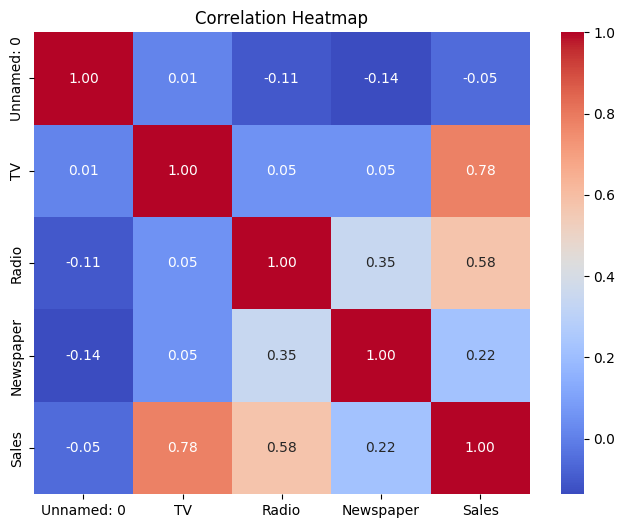

In [10]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

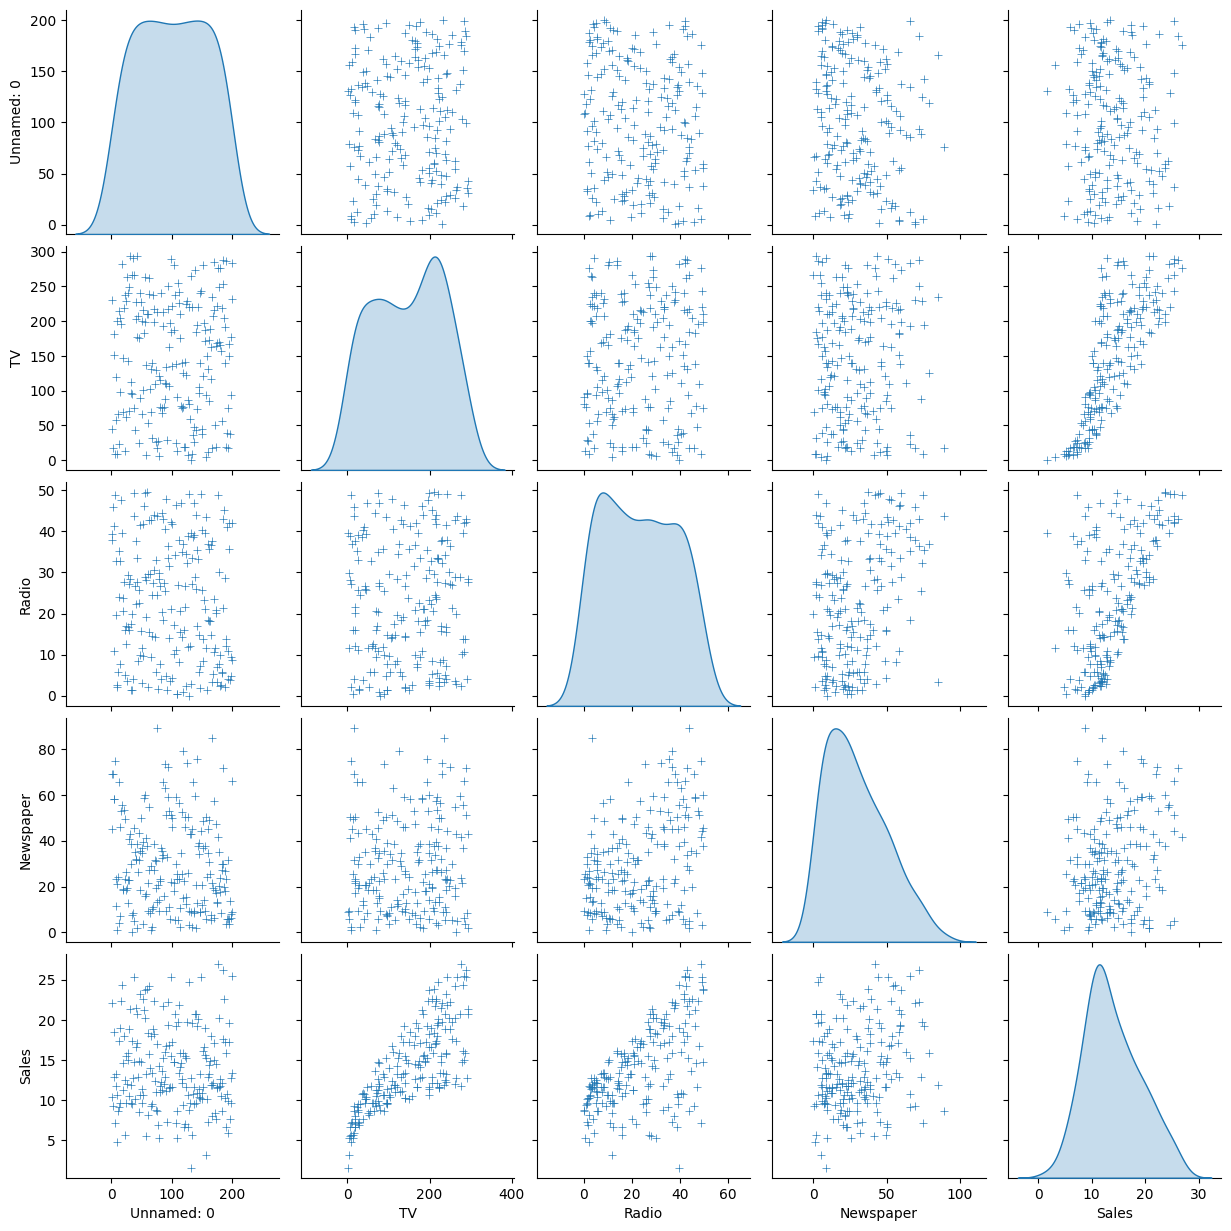

In [11]:
# Pairplot for feature relationships
sns.pairplot(df_cleaned, diag_kind='kde', markers='+')
plt.show()

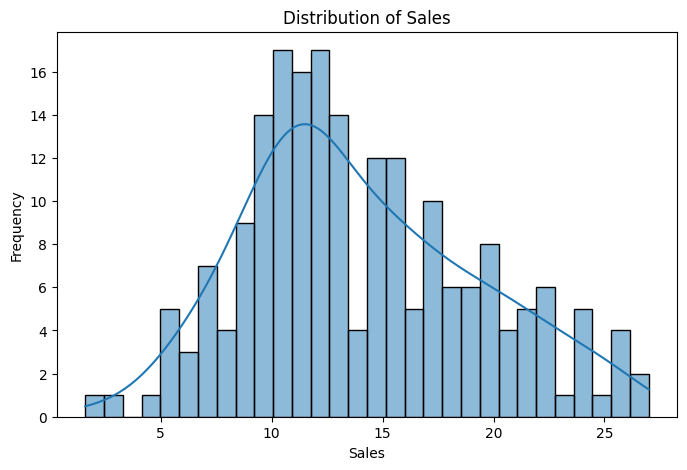

In [15]:
# Distribution of Sales
plt.figure(figsize=(8, 5))
sns.histplot(df['Sales'], kde=True, bins=30)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

## Feature Engineering

In [12]:
# Create Polynomial Features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(df_cleaned[['TV', 'Radio', 'Newspaper']])

In [16]:
# Adding interaction terms (TV_Radio, etc.)
# Use .loc[] to avoid the SettingWithCopyWarning

df_cleaned.loc[:, 'TV_Radio'] = df_cleaned['TV'] * df_cleaned['Radio']
df_cleaned.loc[:, 'TV_Newspaper'] = df_cleaned['TV'] * df_cleaned['Newspaper']
df_cleaned.loc[:, 'Radio_Newspaper'] = df_cleaned['Radio'] * df_cleaned['Newspaper']

X = df_cleaned[['TV', 'Radio', 'Newspaper', 'TV_Radio', 'TV_Newspaper', 'Radio_Newspaper']]  # Features
y = df_cleaned['Sales']  # Target variable


## Split the data into training and testing sets (80% train, 20% test)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardization of features

In [18]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building - Linear Regression and Random Forest Regressor

In [19]:
# Create a pipeline for Random Forest Regressor with feature scaling
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor())
])

In [20]:
# Hyperparameter tuning for Random Forest
param_grid = {'regressor__n_estimators': [50, 100, 200], 'regressor__max_depth': [3, 5, 10]}
grid_search_rf = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': [3, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

## Train the model - Linear Regression

In [21]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

## Evaluate the models

In [22]:
# Predictions for Linear Regression
y_pred_train_lr = linear_model.predict(X_train_scaled)
y_pred_test_lr = linear_model.predict(X_test_scaled)

In [23]:
# Predictions for Random Forest
y_pred_train_rf = grid_search_rf.best_estimator_.predict(X_train)
y_pred_test_rf = grid_search_rf.best_estimator_.predict(X_test)

In [24]:
# Training metrics for Linear Regression
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
train_mae_lr = mean_absolute_error(y_train, y_pred_train_lr)
train_r2_lr = r2_score(y_train, y_pred_train_lr)

In [26]:
print("\nLinear Regression Training Metrics:")
print(f"RMSE: {train_rmse_lr:.2f}, MAE: {train_mae_lr:.2f}, R²: {train_r2_lr:.2f}")


Linear Regression Training Metrics:
RMSE: 0.94, MAE: 0.66, R²: 0.97


In [27]:
# Testing metrics for Linear Regression
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
test_mae_lr = mean_absolute_error(y_test, y_pred_test_lr)
test_r2_lr = r2_score(y_test, y_pred_test_lr)

In [28]:
print("\nLinear Regression Testing Metrics:")
print(f"RMSE: {test_rmse_lr:.2f}, MAE: {test_mae_lr:.2f}, R²: {test_r2_lr:.2f}")


Linear Regression Testing Metrics:
RMSE: 0.89, MAE: 0.72, R²: 0.97


In [29]:
# Training metrics for Random Forest
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)

In [30]:
print("\nRandom Forest Training Metrics:")
print(f"RMSE: {train_rmse_rf:.2f}, MAE: {train_mae_rf:.2f}, R²: {train_r2_rf:.2f}")


Random Forest Training Metrics:
RMSE: 0.22, MAE: 0.16, R²: 1.00


In [31]:
# Testing metrics for Random Forest
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

In [32]:
print("\nRandom Forest Testing Metrics:")
print(f"RMSE: {test_rmse_rf:.2f}, MAE: {test_mae_rf:.2f}, R²: {test_r2_rf:.2f}")


Random Forest Testing Metrics:
RMSE: 0.50, MAE: 0.41, R²: 0.99


## Model Visualization - Residual Plot

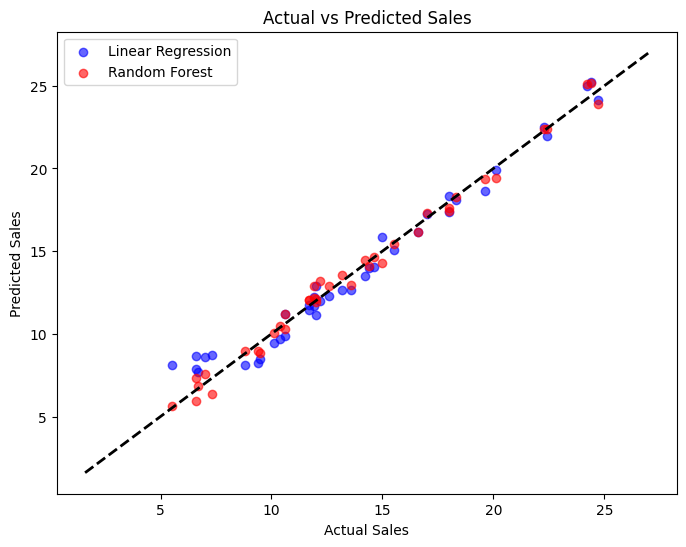

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_lr, color='blue', alpha=0.6, label="Linear Regression")
plt.scatter(y_test, y_pred_test_rf, color='red', alpha=0.6, label="Random Forest")
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='black', linestyle='--', linewidth=2)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()

## SHAP for Model Explainability (Random Forest)

In [36]:
# Extract the RandomForestRegressor model from the pipeline
best_rf_model = grid_search_rf.best_estimator_.named_steps['regressor']

In [37]:
# Use SHAP for model explanation
explainer_rf = shap.TreeExplainer(best_rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

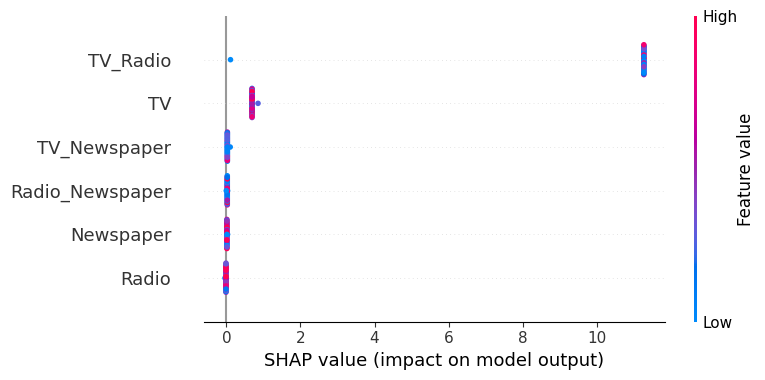

In [38]:
# Summary plot to visualize feature importance
shap.summary_plot(shap_values_rf, X_test)

## Learning Curve for Random Forest

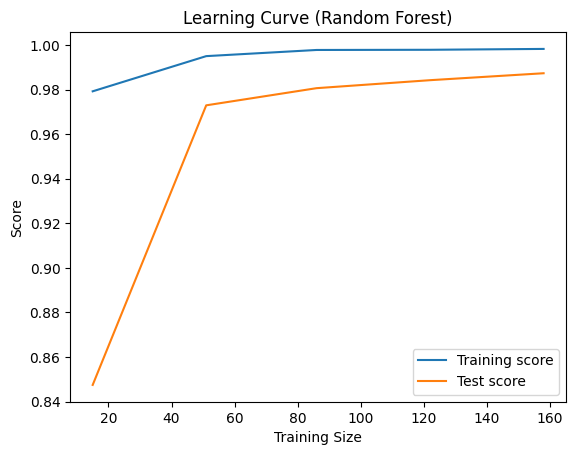

In [39]:
train_sizes, train_scores, test_scores = learning_curve(grid_search_rf.best_estimator_, X, y, cv=5)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.show()

## Save the trained model

In [40]:
import joblib
joblib.dump(grid_search_rf.best_estimator_, "sales_prediction_model_rf.pkl")
joblib.dump(linear_model, "sales_prediction_model_lr.pkl")
print("\nModels saved as 'sales_prediction_model_rf.pkl' and 'sales_prediction_model_lr.pkl'")


Models saved as 'sales_prediction_model_rf.pkl' and 'sales_prediction_model_lr.pkl'
